# Day_083

### 練習時間
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras import optimizers
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

[BatchNormalization 介紹](https://keras.io/layers/normalization/)

BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

In [5]:
from keras.layers import BatchNormalization, Activation
def build_mlp(input_shape, output_units = 10, num_neurons=[512, 256, 128]):
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units = n_units, 
                      activation = "relu", 
                      name = "hidden_layer" + str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = Dense(units = n_units, 
                      activation = "relu", 
                      name = "hidden_layer" + str(i+1))(x)
            x = BatchNormalization()(x)
    
    output = Dense(units = output_units, activation = "softmax", name = "output")(x)
    
    model = Model(inputs = [input_layer], outputs = [output])
    return model

In [6]:
def plt_model_result(result):
    color_bar = ["r", "g", "b", "y", "m", "k"]
    
    plt.figure(figsize=(12, 10))
    for i, cond in enumerate(result.keys()):
        plt.plot(range(len(result[cond]['train-loss'])), result[cond]['train-loss'], '-', label = 'train-' + cond, color = color_bar[i])
        plt.plot(range(len(result[cond]['valid-loss'])), result[cond]['valid-loss'], '--', label = 'valid-' + cond, color = color_bar[i])
    plt.title("Loss")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    plt.figure(figsize=(12, 10))
    for i, cond in enumerate(result.keys()):
        plt.plot(range(len(result[cond]['train-acc'])),result[cond]['train-acc'], '-', label = 'train-' + cond, color = color_bar[i])
        plt.plot(range(len(result[cond]['valid-acc'])),result[cond]['valid-acc'], '--', label = 'valid-' + cond, color = color_bar[i])
    plt.title("Accuracy")
    plt.legend(loc='center left', bbox_to_anchor = (1, 0.5))
    plt.show()

In [7]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128, 256, 1024]
MOMENTUM = 0.95

### 比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異

In [8]:
results = {}
for batch_size in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Batch Size = %.0f" % (batch_size))
    model = build_mlp(input_shape = x_train.shape[1:])
    model.summary()
    optimizer = optimizers.SGD(lr = LEARNING_RATE, nesterov = True, momentum = MOMENTUM)
    model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)

    model.fit(x_train, y_train, 
              epochs = EPOCHS, 
              batch_size = batch_size, 
              validation_data = (x_test, y_test), 
              shuffle = True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-batch_size-%s" % str(batch_size)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Batch Size = 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)     

50000/50000 [==============================] - 454s 9ms/step - loss: 2.2427 - acc: 0.1624 - val_loss: 3.8086 - val_acc: 0.1741
Epoch 50/50
50000/50000 [==============================] - 454s 9ms/step - loss: 2.2404 - acc: 0.1649 - val_loss: 4.0068 - val_acc: 0.1971
Experiment with Batch Size = 16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)  

50000/50000 [==============================] - 76s 2ms/step - loss: 1.1195 - acc: 0.6026 - val_loss: 1.4292 - val_acc: 0.5076
Epoch 48/50
50000/50000 [==============================] - 74s 1ms/step - loss: 1.1186 - acc: 0.6032 - val_loss: 1.3846 - val_acc: 0.5201
Epoch 49/50
50000/50000 [==============================] - 74s 1ms/step - loss: 1.1241 - acc: 0.6017 - val_loss: 1.3809 - val_acc: 0.5209
Epoch 50/50
50000/50000 [==============================] - 74s 1ms/step - loss: 1.1261 - acc: 0.6000 - val_loss: 1.3785 - val_acc: 0.5201
Experiment with Batch Size = 32
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (No

50000/50000 [==============================] - 43s 852us/step - loss: 0.8152 - acc: 0.7101 - val_loss: 1.5725 - val_acc: 0.5042
Epoch 46/50
50000/50000 [==============================] - 43s 858us/step - loss: 0.8167 - acc: 0.7092 - val_loss: 1.5460 - val_acc: 0.5069
Epoch 47/50
50000/50000 [==============================] - 43s 863us/step - loss: 0.8171 - acc: 0.7093 - val_loss: 1.5165 - val_acc: 0.5107
Epoch 48/50
50000/50000 [==============================] - 43s 858us/step - loss: 0.8079 - acc: 0.7120 - val_loss: 1.5366 - val_acc: 0.5153
Epoch 49/50
50000/50000 [==============================] - 43s 857us/step - loss: 0.7927 - acc: 0.7180 - val_loss: 1.5683 - val_acc: 0.5151
Epoch 50/50
50000/50000 [==============================] - 43s 862us/step - loss: 0.7964 - acc: 0.7165 - val_loss: 1.5628 - val_acc: 0.5076
Experiment with Batch Size = 128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1

50000/50000 [==============================] - 22s 449us/step - loss: 0.3208 - acc: 0.8910 - val_loss: 2.5425 - val_acc: 0.4421
Epoch 44/50
50000/50000 [==============================] - 22s 444us/step - loss: 0.3105 - acc: 0.8947 - val_loss: 2.3222 - val_acc: 0.4729
Epoch 45/50
50000/50000 [==============================] - 22s 447us/step - loss: 0.2934 - acc: 0.9011 - val_loss: 2.4397 - val_acc: 0.4583
Epoch 46/50
50000/50000 [==============================] - 23s 453us/step - loss: 0.3009 - acc: 0.8973 - val_loss: 2.2898 - val_acc: 0.4846
Epoch 47/50
50000/50000 [==============================] - 22s 447us/step - loss: 0.2765 - acc: 0.9049 - val_loss: 2.4985 - val_acc: 0.4559
Epoch 48/50
50000/50000 [==============================] - 23s 450us/step - loss: 0.2798 - acc: 0.9041 - val_loss: 2.4844 - val_acc: 0.4556
Epoch 49/50
50000/50000 [==============================] - 22s 449us/step - loss: 0.2664 - acc: 0.9089 - val_loss: 2.4423 - val_acc: 0.4714
Epoch 50/50
50000/50000 [=======

50000/50000 [==============================] - 18s 353us/step - loss: 0.2767 - acc: 0.9168 - val_loss: 2.2084 - val_acc: 0.4578
Epoch 42/50
50000/50000 [==============================] - 18s 352us/step - loss: 0.2628 - acc: 0.9217 - val_loss: 2.2381 - val_acc: 0.4537
Epoch 43/50
50000/50000 [==============================] - 18s 353us/step - loss: 0.2474 - acc: 0.9270 - val_loss: 2.2047 - val_acc: 0.4569
Epoch 44/50
50000/50000 [==============================] - 19s 370us/step - loss: 0.2335 - acc: 0.9316 - val_loss: 2.3250 - val_acc: 0.4793
Epoch 45/50
50000/50000 [==============================] - 18s 354us/step - loss: 0.2174 - acc: 0.9384 - val_loss: 2.2950 - val_acc: 0.4715
Epoch 46/50
50000/50000 [==============================] - 18s 353us/step - loss: 0.2124 - acc: 0.9402 - val_loss: 2.3114 - val_acc: 0.4659
Epoch 47/50
50000/50000 [==============================] - 18s 354us/step - loss: 0.2036 - acc: 0.9415 - val_loss: 2.2792 - val_acc: 0.4722
Epoch 48/50
50000/50000 [=======

50000/50000 [==============================] - 15s 298us/step - loss: 0.6696 - acc: 0.7899 - val_loss: 1.5573 - val_acc: 0.4912
Epoch 40/50
50000/50000 [==============================] - 15s 310us/step - loss: 0.6518 - acc: 0.7982 - val_loss: 1.5611 - val_acc: 0.4922
Epoch 41/50
50000/50000 [==============================] - 15s 306us/step - loss: 0.6328 - acc: 0.8060 - val_loss: 1.5731 - val_acc: 0.4927
Epoch 42/50
50000/50000 [==============================] - 15s 296us/step - loss: 0.6125 - acc: 0.8153 - val_loss: 1.5855 - val_acc: 0.4827
Epoch 43/50
50000/50000 [==============================] - 15s 298us/step - loss: 0.5975 - acc: 0.8195 - val_loss: 1.5831 - val_acc: 0.4914
Epoch 44/50
50000/50000 [==============================] - 15s 296us/step - loss: 0.5782 - acc: 0.8267 - val_loss: 1.6066 - val_acc: 0.4888
Epoch 45/50
50000/50000 [==============================] - 15s 294us/step - loss: 0.5604 - acc: 0.8348 - val_loss: 1.6108 - val_acc: 0.4859
Epoch 46/50
50000/50000 [=======

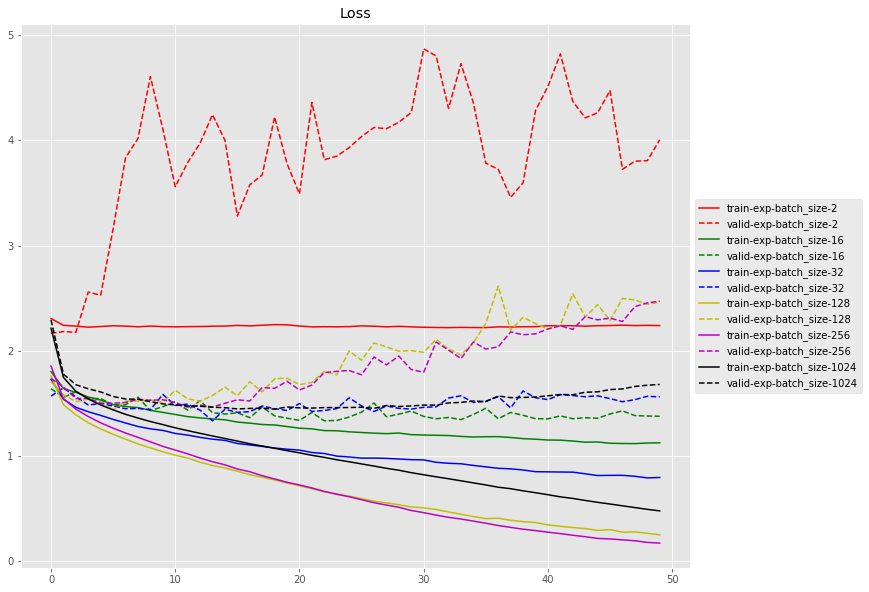

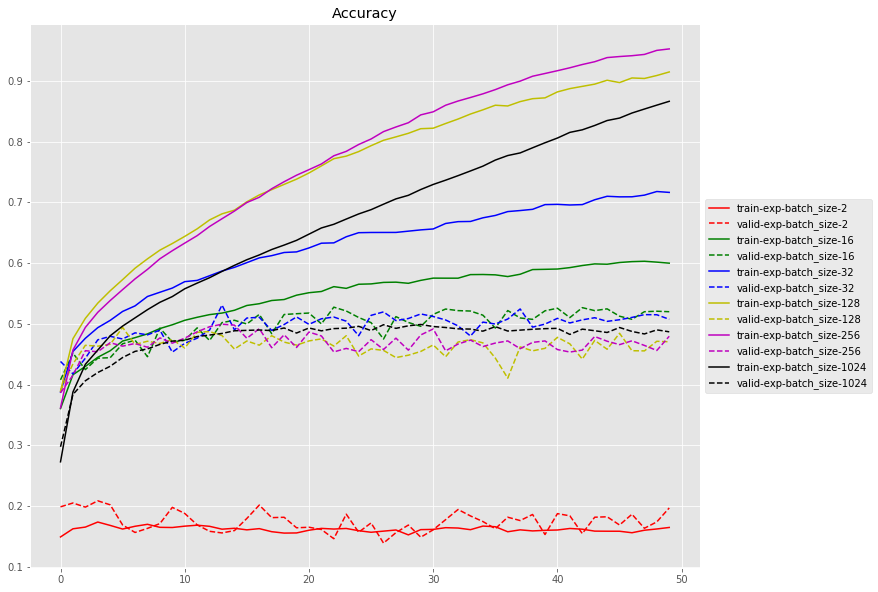

In [9]:
plt_model_result(results)

### 將 BN 放在 Activation 之前

In [10]:
def build_mlp_Activation(input_shape, output_units = 10, num_neurons=[512, 256, 128]):
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units = n_units,                       
                      name = "hidden_layer" + str(i+1))(input_layer)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        else:
            x = Dense(units = n_units,                    
                      name = "hidden_layer" + str(i+1))(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
    
    output = Dense(units = output_units, activation = "softmax", name = "output")(x)
    
    model = Model(inputs = [input_layer], outputs = [output])
    return model

In [12]:
results = {}
for batch_size in [128, 256, 1024]:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Batch Size = %.0f" % (batch_size))
    model = build_mlp_Activation(input_shape = x_train.shape[1:])
    model.summary()
    optimizer = optimizers.SGD(lr = LEARNING_RATE, nesterov = True, momentum = MOMENTUM)
    model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)

    model.fit(x_train, y_train, 
              epochs = EPOCHS, 
              batch_size = batch_size, 
              validation_data = (x_test, y_test), 
              shuffle = True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-batch_size-%s" % str(batch_size)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Batch Size = 128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)   

50000/50000 [==============================] - 22s 442us/step - loss: 0.0591 - acc: 0.9848 - val_loss: 2.9506 - val_acc: 0.4706
Epoch 47/50
50000/50000 [==============================] - 22s 446us/step - loss: 0.0575 - acc: 0.9849 - val_loss: 2.9909 - val_acc: 0.4659
Epoch 48/50
50000/50000 [==============================] - 22s 447us/step - loss: 0.0620 - acc: 0.9832 - val_loss: 2.9940 - val_acc: 0.4515
Epoch 49/50
50000/50000 [==============================] - 22s 443us/step - loss: 0.0544 - acc: 0.9861 - val_loss: 2.8263 - val_acc: 0.4893
Epoch 50/50
50000/50000 [==============================] - 22s 445us/step - loss: 0.0517 - acc: 0.9870 - val_loss: 3.0061 - val_acc: 0.4727
Experiment with Batch Size = 256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (

50000/50000 [==============================] - 18s 354us/step - loss: 0.0665 - acc: 0.9913 - val_loss: 2.5054 - val_acc: 0.4668
Epoch 42/50
50000/50000 [==============================] - 18s 355us/step - loss: 0.0617 - acc: 0.9921 - val_loss: 2.5545 - val_acc: 0.4656
Epoch 43/50
50000/50000 [==============================] - 18s 354us/step - loss: 0.0588 - acc: 0.9928 - val_loss: 2.5169 - val_acc: 0.4839
Epoch 44/50
50000/50000 [==============================] - 18s 354us/step - loss: 0.0516 - acc: 0.9940 - val_loss: 2.6036 - val_acc: 0.4774
Epoch 45/50
50000/50000 [==============================] - 18s 354us/step - loss: 0.0472 - acc: 0.9948 - val_loss: 2.5863 - val_acc: 0.4883
Epoch 46/50
50000/50000 [==============================] - 18s 356us/step - loss: 0.0459 - acc: 0.9957 - val_loss: 2.5283 - val_acc: 0.4957
Epoch 47/50
50000/50000 [==============================] - 18s 359us/step - loss: 0.0406 - acc: 0.9960 - val_loss: 2.6051 - val_acc: 0.4838
Epoch 48/50
50000/50000 [=======

50000/50000 [==============================] - 15s 294us/step - loss: 0.7993 - acc: 0.7495 - val_loss: 1.4340 - val_acc: 0.5039
Epoch 37/50
50000/50000 [==============================] - 15s 293us/step - loss: 0.7801 - acc: 0.7581 - val_loss: 1.4342 - val_acc: 0.5028
Epoch 38/50
50000/50000 [==============================] - 15s 293us/step - loss: 0.7603 - acc: 0.7661 - val_loss: 1.4400 - val_acc: 0.5010
Epoch 39/50
50000/50000 [==============================] - 15s 291us/step - loss: 0.7407 - acc: 0.7731 - val_loss: 1.4457 - val_acc: 0.5054
Epoch 40/50
50000/50000 [==============================] - 15s 292us/step - loss: 0.7221 - acc: 0.7805 - val_loss: 1.4578 - val_acc: 0.4996
Epoch 41/50
50000/50000 [==============================] - 15s 292us/step - loss: 0.7034 - acc: 0.7876 - val_loss: 1.4639 - val_acc: 0.5021
Epoch 42/50
50000/50000 [==============================] - 15s 292us/step - loss: 0.6831 - acc: 0.7964 - val_loss: 1.4743 - val_acc: 0.4989
Epoch 43/50
50000/50000 [=======

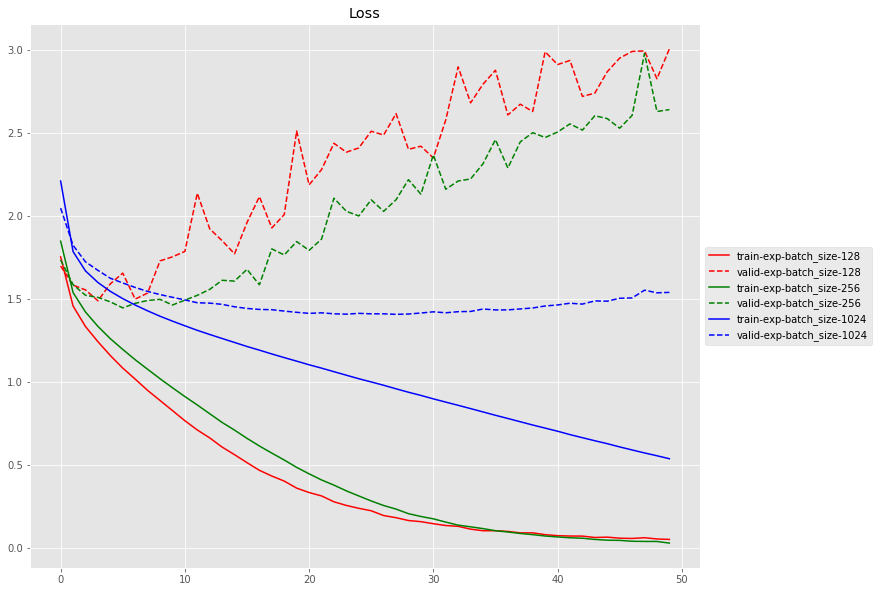

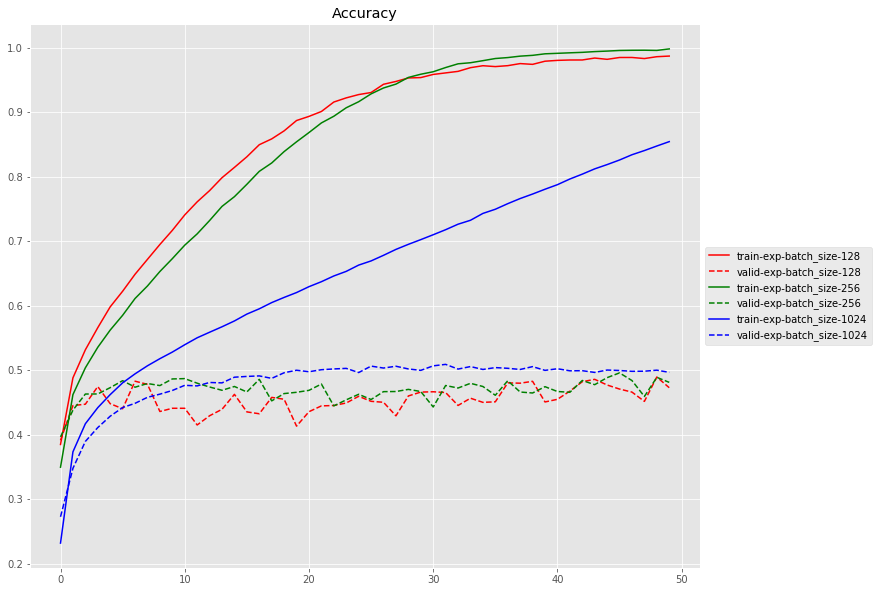

In [13]:
plt_model_result(results)

### 將 BN 放在 Input Layer 後

In [14]:
def build_mlp_InputLayer(input_shape, output_units = 10, num_neurons=[512, 256, 128]):
    input_layer = Input(input_shape)
    x = BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units = n_units, 
                      activation = "relu", 
                      name = "hidden_layer" + str(i+1))(x) 
        else:
            x = Dense(units = n_units,  
                      activation = "relu", 
                      name = "hidden_layer" + str(i+1))(x)         
    
    output = Dense(units = output_units, activation = "softmax", name = "output")(x)
    
    model = Model(inputs = [input_layer], outputs = [output])
    return model

In [15]:
results = {}
for batch_size in [128, 256, 1024]:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Batch Size = %.0f" % (batch_size))
    model = build_mlp_InputLayer(input_shape = x_train.shape[1:])
    model.summary()
    optimizer = optimizers.SGD(lr = LEARNING_RATE, nesterov = True, momentum = MOMENTUM)
    model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)

    model.fit(x_train, y_train, 
              epochs = EPOCHS, 
              batch_size = batch_size, 
              validation_data = (x_test, y_test), 
              shuffle = True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-batch_size-%s" % str(batch_size)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Batch Size = 128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,751,178
Trainable params: 1,745,034
Non-trainable params: 6,144
_____________________________

Experiment with Batch Size = 256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,751,178
Trainable params: 1,745,034
Non-trainable params: 6,144
_____________________________

Experiment with Batch Size = 1024
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,751,178
Trainable params: 1,745,034
Non-trainable params: 6,144
____________________________

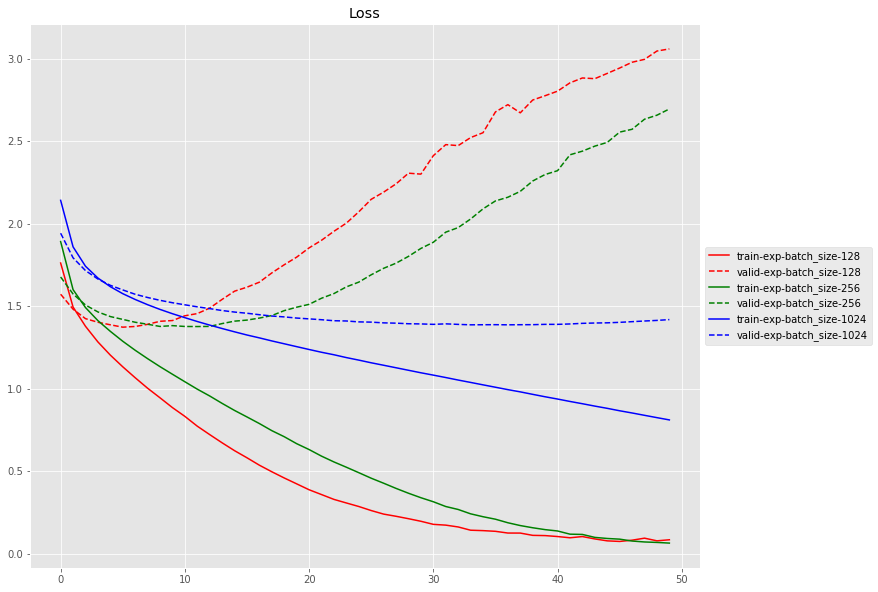

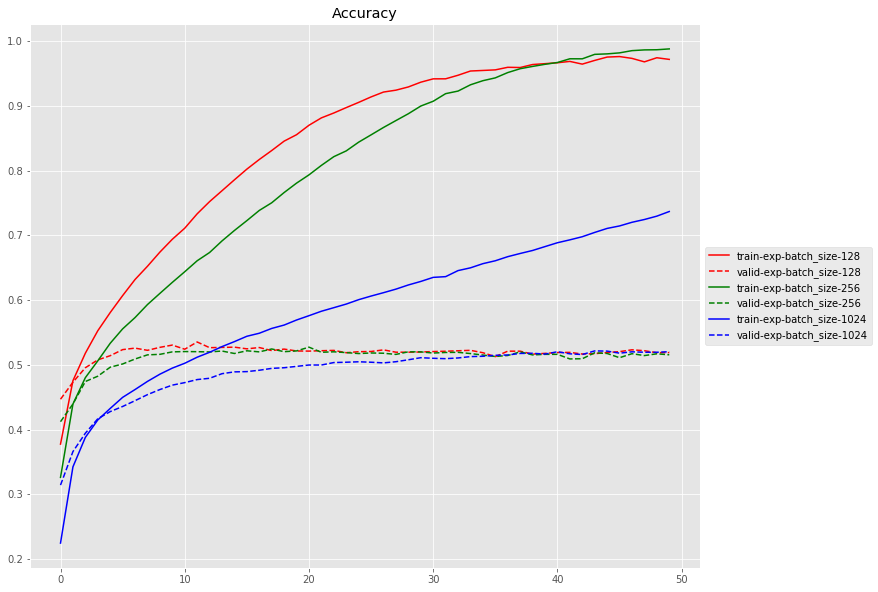

In [16]:
plt_model_result(results)